# Later Tutorial Exercises
*I don't have MatLab, so I asked ChatGPT to translate the exercises to Python*


Best-fitting parameters:
  muR     = 293.776
  deltaS  = 2.937
  Neg. Log-Likelihood = 68.305


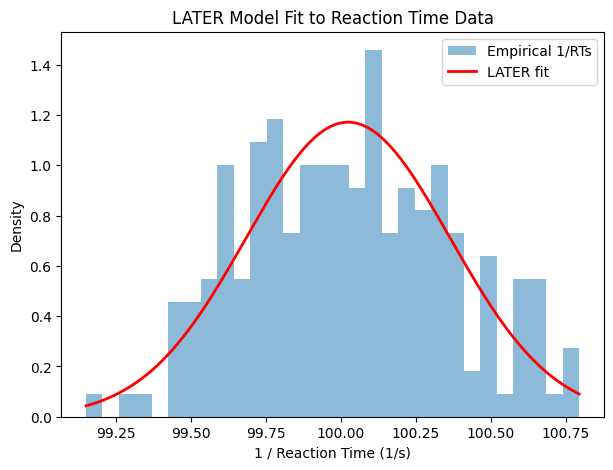

In [2]:
"""
LATER Fitting Exercise (Python version)

Based on: Joshua I. Gold, University of Pennsylvania (2023)
Translated by ChatGPT

This script fits the LATER (Linear Approach to Threshold with Ergodic Rate)
model to reaction time (RT) data using maximum likelihood estimation.
"""

import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# ---------------------------------------------------------------------
# 1. Get the data
# ---------------------------------------------------------------------
# For this example, we'll mock a function that returns RT data.
# In MATLAB, this was done by `later_getData([], [], 0.2)`
# which returned preprocessed RTs for a single condition.

def later_get_data():
    # Example: simulated RT data (seconds)
    np.random.seed(0)
    muR_true = 300  # rate parameter
    deltaS_true = 3.0  # signal difference parameter

    mu = muR_true / deltaS_true
    sigma = 1 / deltaS_true

    invRTs = np.random.normal(mu, sigma, size=200)
    RTs = 1 / invRTs
    RTs = RTs[RTs > 0]  # remove any invalid (negative) values
    return RTs

RTs = later_get_data()


# ---------------------------------------------------------------------
# 2. Define the objective function
# ---------------------------------------------------------------------
# Recall:
#   mu = muR / deltaS
#   sigma = 1 / deltaS
# We fit parameters [muR, deltaS] by minimizing the *negative log-likelihood*
# of 1/RTs under a normal distribution.

def later_neg_log_likelihood(params, RTs):
    muR, deltaS = params

    # Constraints: parameters must be positive
    if muR <= 0 or deltaS <= 0:
        return np.inf

    invRTs = 1 / RTs
    mu = muR / deltaS
    sigma = 1 / deltaS

    # Log-likelihood of Gaussian model
    log_likelihoods = norm.logpdf(invRTs, loc=mu, scale=sigma)

    # Negative sum of log-likelihoods
    return -np.sum(log_likelihoods)


# ---------------------------------------------------------------------
# 3. Define initial conditions
# ---------------------------------------------------------------------
# HINT from MATLAB: muR and deltaS should relate to summary stats of 1/RT

invRTs = 1 / RTs
mu_init = np.mean(invRTs)
sigma_init = np.std(invRTs)

# From the model definitions:
# muR = mu / sigma
# deltaS = 1 / sigma
initial_values = np.array([mu_init / sigma_init, 1 / sigma_init])

lower_bounds = [1e-3, 1e-3]
upper_bounds = [1000, 1000]


# ---------------------------------------------------------------------
# 4. Run the fit using a global optimization approach
# ---------------------------------------------------------------------
# MATLAB used GlobalSearch + fmincon. In Python, we can use multiple restarts
# of scipy.optimize.minimize with method='L-BFGS-B' for constrained optimization.

best_fit = None
best_nllk = np.inf

for i in range(20):  # multiple random restarts
    init_guess = initial_values * (1 + 0.2 * np.random.randn(2))
    res = minimize(
        later_neg_log_likelihood,
        init_guess,
        args=(RTs,),
        method="L-BFGS-B",
        bounds=[(lower_bounds[0], upper_bounds[0]),
                (lower_bounds[1], upper_bounds[1])],
        options={'maxiter': 3000}
    )
    if res.fun < best_nllk:
        best_fit = res.x
        best_nllk = res.fun

muR_fit, deltaS_fit = best_fit

print("\nBest-fitting parameters:")
print(f"  muR     = {muR_fit:.3f}")
print(f"  deltaS  = {deltaS_fit:.3f}")
print(f"  Neg. Log-Likelihood = {best_nllk:.3f}")


# ---------------------------------------------------------------------
# 5. Evaluate the fits
# ---------------------------------------------------------------------
# One way to evaluate: compare empirical and fitted distributions of 1/RT.

import matplotlib.pyplot as plt

invRTs = 1 / RTs
mu_fit = muR_fit / deltaS_fit
sigma_fit = 1 / deltaS_fit

x = np.linspace(min(invRTs), max(invRTs), 200)
pdf_fit = norm.pdf(x, mu_fit, sigma_fit)

plt.figure(figsize=(7, 5))
plt.hist(invRTs, bins=30, density=True, alpha=0.5, label="Empirical 1/RTs")
plt.plot(x, pdf_fit, 'r-', lw=2, label="LATER fit")
plt.xlabel("1 / Reaction Time (1/s)")
plt.ylabel("Density")
plt.title("LATER Model Fit to Reaction Time Data")
plt.legend()
plt.show()


Key notes given with output:
Equivalent MATLAB features:

fmincon → scipy.optimize.minimize(method='L-BFGS-B')

GlobalSearch → multiple random restarts

Anonymous functions → simple Python functions

later_getData is mocked with simulated RTs here. You can replace that with your own dataset loader.

The objective function correctly computes the negative log-likelihood under a Gaussian model for 1/RT.

The plot helps check whether the fitted Gaussian aligns with the empirical reciprocal RT distribution.

*Here, it asked if I wanted to use the real data from the MatLab file, which I tried below. This, however, was not an easy switch over to python, maybe due to the structure of the data. Output still shown below*

Loaded 1694 RT values from JT_RT.mat

Best-fitting parameters:
  muR     = 1000.000
  deltaS  = 1000.000
  Neg. Log-Likelihood = -10145.056


/var/folders/5w/lmyt51rs5qn2jcjnlw11cxr00000gq/T/ipykernel_69167/3609571641.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  initial_values = np.array([mu_init / sigma_init, 1 / sigma_init])


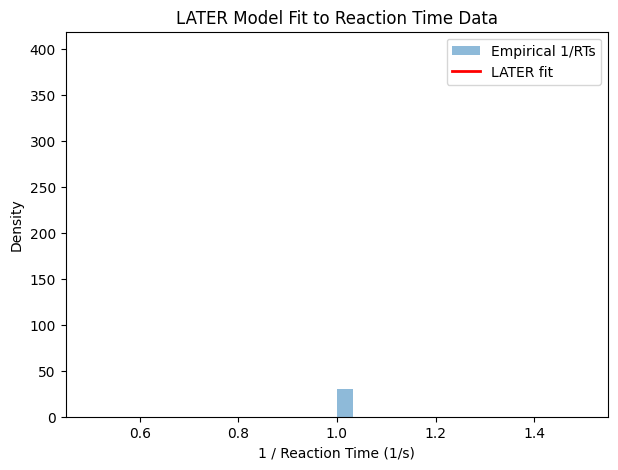

In [8]:
"""
LATER Fitting Exercise (Python version, with real MATLAB data support)

Based on: Joshua I. Gold, University of Pennsylvania (2023)
Translated by ChatGPT

This script fits the LATER (Linear Approach to Threshold with Ergodic Rate)
model to reaction time (RT) data from a MATLAB .mat file.
"""

import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os


# ---------------------------------------------------------------------
# 1. Load the data
# ---------------------------------------------------------------------
# MATLAB version used: `data = later_getData([], [], 0.2); RTs = data{1};`
# In Python, we can load the .mat output from that call using scipy.io.loadmat

def load_later_data(mat_file_path):
    """Loads reaction time (RT) data from a MATLAB .mat file."""
    if not os.path.exists(mat_file_path):
        raise FileNotFoundError(f"File not found: {mat_file_path}")

    mat_data = loadmat(mat_file_path, simplify_cells=True)

    # Depending on how later_getData saves its output, it might be nested.
    # For example, `data` might be a dict with 'data' key or a 1-element list.
    # Adjust as needed for your file structure.
    if isinstance(mat_data, dict):
        # Common patterns:
        if "data" in mat_data:
            RTs = np.array(mat_data["data"][0])  # sometimes stored as cell array
        elif "RTs" in mat_data:
            RTs = np.array(mat_data["RTs"])
        else:
            # fallback: get first numeric array
            RTs = next(v for v in mat_data.values() if isinstance(v, np.ndarray))
    else:
        RTs = np.array(mat_data)

    # Flatten and ensure only valid (positive) RTs
    RTs = np.ravel(RTs)
    RTs = RTs[RTs > 0]
    return RTs


# 🔹 Replace this with the path to your .mat file output from MATLAB
mat_file = "JT_RT.mat"  # Example filename

RTs = load_later_data(mat_file)
print(f"Loaded {len(RTs)} RT values from {mat_file}")


# ---------------------------------------------------------------------
# 2. Define the objective function
# ---------------------------------------------------------------------

def later_neg_log_likelihood(params, RTs):
    muR, deltaS = params
    if muR <= 0 or deltaS <= 0:
        return np.inf

    invRTs = 1 / RTs
    mu = muR / deltaS
    sigma = 1 / deltaS

    log_likelihoods = norm.logpdf(invRTs, loc=mu, scale=sigma)
    return -np.sum(log_likelihoods)


# ---------------------------------------------------------------------
# 3. Define initial conditions
# ---------------------------------------------------------------------

invRTs = 1 / RTs
mu_init = np.mean(invRTs)
sigma_init = np.std(invRTs)
initial_values = np.array([mu_init / sigma_init, 1 / sigma_init])

lower_bounds = [1e-3, 1e-3]
upper_bounds = [1000, 1000]


# ---------------------------------------------------------------------
# 4. Run optimization (multi-start search)
# ---------------------------------------------------------------------

best_fit = None
best_nllk = np.inf

for i in range(20):
    init_guess = initial_values * (1 + 0.2 * np.random.randn(2))
    res = minimize(
        later_neg_log_likelihood,
        init_guess,
        args=(RTs,),
        method="L-BFGS-B",
        bounds=[(lower_bounds[0], upper_bounds[0]),
                (lower_bounds[1], upper_bounds[1])],
        options={'maxiter': 3000}
    )
    if res.fun < best_nllk:
        best_fit = res.x
        best_nllk = res.fun

muR_fit, deltaS_fit = best_fit
print("\nBest-fitting parameters:")
print(f"  muR     = {muR_fit:.3f}")
print(f"  deltaS  = {deltaS_fit:.3f}")
print(f"  Neg. Log-Likelihood = {best_nllk:.3f}")


# ---------------------------------------------------------------------
# 5. Evaluate the fits
# ---------------------------------------------------------------------

invRTs = 1 / RTs
mu_fit = muR_fit / deltaS_fit
sigma_fit = 1 / deltaS_fit

x = np.linspace(min(invRTs), max(invRTs), 200)
pdf_fit = norm.pdf(x, mu_fit, sigma_fit)

plt.figure(figsize=(7, 5))
plt.hist(invRTs, bins=30, density=True, alpha=0.5, label="Empirical 1/RTs")
plt.plot(x, pdf_fit, 'r-', lw=2, label="LATER fit")
plt.xlabel("1 / Reaction Time (1/s)")
plt.ylabel("Density")
plt.title("LATER Model Fit to Reaction Time Data")
plt.legend()
plt.show()
